In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
class TransformerMultiTask(nn.Module):
    def __init__(self, input_dim, num_heads:int, num_layers:int, hidden_dim:int, 
                 entity_id_cls:int, entity_state_cls:int, additional_input_dim:int = 0):
        super(TransformerMultiTask, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        # Separate heads for classification tasks
        # Simpler actionable classification head
        self.actionable_fc = nn.Linear(hidden_dim + additional_input_dim, 2)
        
        # Head for complex entity ID classification
        self.entity_id_fc = nn.Sequential(
            nn.Linear(hidden_dim + additional_input_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, entity_id_cls)
        )
        
        # Head for entity state classification
        #  - takes the additional inputs and also the outputs of the entity classifications
        self.entity_state_fc = nn.Sequential(
            nn.Linear(hidden_dim + additional_input_dim + entity_id_cls, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, entity_state_cls)
        )
        
    def forward(self, sequence, additional_inputs=None):
        # x shape: (batch_size, seq_length, input_dim)
        embed = self.embedding(sequence)
        x = self.transformer(embed)
        
        # Take the mean across the sequence dimension
        x = x.mean(dim=1)

        # If additional inputs are provided, concatenate them with x
        if additional_inputs is not None:
            x = torch.cat((x, additional_inputs), dim=-1)
        
        # Separate heads for classification and regression
        actionable_output = self.actionable_fc(x)
        entity_id_output = self.entity_id_fc(x)
        # Concatenate x with entity_id_output before passing to entity_state_fc
        x_with_entity_id = torch.cat((x, entity_id_output), dim=-1)
        entity_state_output = self.entity_state_fc(x_with_entity_id)
        
        # return actionable_output, entity_id_output, entity_state_output
        return actionable_output, entity_id_output, entity_state_output

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
import os
import random
import io
import numpy as np
import pandas as pd
import warnings

# Helper function to convert bytes back to tensor
def bytes_to_tensor(tensor_bytes):
    buffer = io.BytesIO(tensor_bytes)
    loaded_tensor = torch.load(buffer, weights_only=True)
    return loaded_tensor

from torch.utils.data import DataLoader

class MultiPartParquetCASASDataset(IterableDataset):
    def __init__(self, file_list, shuffle_files=True, shuffle_rows=True):
        self.file_list = file_list
        self.shuffle_files = shuffle_files
        self.shuffle_rows = shuffle_rows
        
        if self.shuffle_files:
            random.shuffle(self.file_list)  # Shuffle the order of files

    def _read_parquet_file(self, file_path):
        df = pd.read_parquet(file_path)

        if self.shuffle_rows:
            df = df.sample(frac=1).reset_index(drop=True)  # Shuffle rows within the dataframe

        return df

    def __len__(self):
        total_len = 0
        for file in self.file_list:
            df = self._read_parquet_file(file)
            total_len += len(df)
        return total_len
    
    def __iter__(self):
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            for file in self.file_list:
                df = self._read_parquet_file(file)
                for _, row in df.iterrows():
                    # shape(batch_size, sequence_length(var))
                    input_tensor = bytes_to_tensor(row['sequence']) 
                    # additional inputs
                    curr_time_hint_tensors = torch.tensor(row[['min', 'hour', 'day', 'week', 'month']])
                    # y labels
                    actionable_tensor = torch.tensor(not row['sensor_change'], dtype=torch.long)
                    action_entity_id_tensor = torch.tensor(row['changed_entity_id'], dtype=torch.long)
                    action_entity_state_tensor = torch.tensor(float(row['changed_entity_value']), dtype=torch.long)
    
                    yield input_tensor, curr_time_hint_tensors, actionable_tensor, action_entity_id_tensor, action_entity_state_tensor


def split_file_list(file_list, train_ratio=0.8, test_ratio=0.1, eval_ratio=0.1):
    """
    Split the list of files into train/test/eval based on the given ratios.
    """
    assert train_ratio + test_ratio + eval_ratio == 1.0, "Ratios must sum to 1"
    
    # Shuffle the file list to ensure randomness
    random.shuffle(file_list)
    
    # Split based on the ratio
    total_files = len(file_list)
    train_end = int(train_ratio * total_files)
    test_end = train_end + int(test_ratio * total_files)
    
    train_files = file_list[:train_end]
    test_files = file_list[train_end:test_end]
    eval_files = file_list[test_end:]
    
    return train_files, test_files, eval_files

def _collate_fn(batch):
    # Separate inputs and targets
    input_tensors, curr_time_hint_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors = zip(*batch)
    
    # Pad sequences for inputs (batch_first=True makes it [batch_size, seq_len, features])
    input_tensors_padded = pad_sequence(input_tensors, batch_first=True)
    # stack the additional inputs
    curr_time_hint_tensors = torch.stack(curr_time_hint_tensors)
    
    # Convert targets to tensors (they should all have the same length as they're scalar values)
    actionable_tensors = torch.stack(actionable_tensors)
    action_entity_id_tensors = torch.stack(action_entity_id_tensors)
    action_entity_state_tensors = torch.stack(action_entity_state_tensors)
    
    return input_tensors_padded, curr_time_hint_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors


# Training

In [28]:
model_save_path = 'transformer_multi_task_slim_128.pth'

In [4]:
import torch
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

def train_act_model(model, dataloader, num_epochs, 
                actionable_classification_criterion, 
                entity_id_classification_criterion, 
                entity_state_classification_criterion, 
                optimizer, device):
    # Store accuracies and time prediction losses
    actionable_accuracies = []
    entity_id_accuracies = []
    entity_state_accuracies = []
    
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_entity_state = 0
        total_entity_state = 0
        correct_entity_id = 0
        total_entity_id = 0
        
        for batch_idx, (input_tensors_padded, curr_time_hint_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors) in tqdm(enumerate(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Assuming the dataloader returns a dictionary-like batch with relevant keys
            inputs = input_tensors_padded.to(device)  # shape: (batch_size, max_seq_length, input_dim)
            time_hint_inputs = curr_time_hint_tensors.to(device)
            actionable_labels = actionable_tensors.to(device)  # shape: (batch_size,)
            entity_id_labels = action_entity_id_tensors.to(device)  # shape: (batch_size,)
            entity_state_labels = action_entity_state_tensors.to(device)  # shape: (batch_size,)

            optimizer.zero_grad()

            # Forward pass
            actionable_output, entity_id_output, entity_state_output = model(inputs, additional_inputs=time_hint_inputs)
            
            # Compute losses
            entity_id_loss = entity_id_classification_criterion(entity_id_output, entity_id_labels)
            entity_state_loss = entity_state_classification_criterion(entity_state_output, entity_state_labels)
            
            # Total loss
            total_loss = entity_id_loss * 8 + entity_state_loss * 2
            
            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            # accumulate the epoch loss
            epoch_loss += total_loss.item()
            
            # Calculate entity ID classification accuracy
            _, predicted_entity_id = torch.max(entity_id_output, 1)
            correct_entity_id += (predicted_entity_id == entity_id_labels).sum().item()
            total_entity_id += entity_id_labels.size(0)

            # Calculate entity state classification accuracy
            _, predicted_entity_state = torch.max(entity_state_output, 1)
            correct_entity_state += (predicted_entity_state == entity_state_labels).sum().item()
            total_entity_state += entity_state_labels.size(0)
            
        # Print epoch stats
        avg_loss = epoch_loss / len(dataloader)
        entity_id_accuracy = 100 * correct_entity_id / total_entity_id
        entity_id_accuracies.append(entity_id_accuracy)
        entity_state_accuracy = 100 * correct_entity_state / total_entity_state
        entity_state_accuracies.append(entity_state_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Entity ID Acc: {entity_id_accuracy:.4f}%, Entity state Acc: {entity_state_accuracy:.2f}%")

    print("Act Training Complete!")
    return actionable_accuracies, entity_id_accuracies, entity_state_accuracies

In [43]:
from os import listdir
from os.path import isfile, join
import re
data_root_path = './data/training_act'
data_pattern = r"^training_data_chunk_slim_activity_slim_\d+\.parquet"
file_list = [join(data_root_path, f) for f in listdir(data_root_path) if isfile(join(data_root_path, f)) and re.match(data_pattern, f)]
# Split the file list
train_files, test_files, eval_files = split_file_list(file_list, train_ratio=0.8, test_ratio=0.1, eval_ratio=0.1)

# Create separate datasets
train_dataset = MultiPartParquetCASASDataset(train_files, shuffle_files=True, shuffle_rows=True)
test_dataset = MultiPartParquetCASASDataset(test_files, shuffle_files=False, shuffle_rows=False)
eval_dataset = MultiPartParquetCASASDataset(eval_files, shuffle_files=False, shuffle_rows=False)

# Wrap them in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)

# Entity ID Classification Criterion (multi-class classification)
entity_id_classification_criterion = nn.CrossEntropyLoss()

# Entity State Classification Criterion (multi-class classification)
entity_state_classification_criterion = nn.CrossEntropyLoss()


In [6]:
# define the model
model = TransformerMultiTask(input_dim=46, hidden_dim=512, additional_input_dim=5, num_heads=2, num_layers=1, entity_id_cls=45, entity_state_cls=4)
training_epoch = 128
# Using Adam optimizer
import torch.optim as optim
learning_rate = 1e-4  # You can adjust the learning rate as needed
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# find the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# start the training
_, entity_id_accuracies, entity_state_accuracies = train_act_model(model=model, dataloader=train_loader, num_epochs=training_epoch, 
            actionable_classification_criterion=actionable_classification_criterion, 
            entity_id_classification_criterion=entity_id_classification_criterion, 
            entity_state_classification_criterion=entity_state_classification_criterion, 
            optimizer=optimizer, device=device)

Epoch 1/128: 15it [00:07,  2.12it/s]


Epoch [1/128], Loss: 28.1122, Entity ID Acc: 9.1102%, Entity state Acc: 52.54%


Epoch 2/128: 15it [00:06,  2.31it/s]


Epoch [2/128], Loss: 22.5916, Entity ID Acc: 15.9958%, Entity state Acc: 59.32%


Epoch 3/128: 15it [00:06,  2.30it/s]


Epoch [3/128], Loss: 20.3315, Entity ID Acc: 21.9280%, Entity state Acc: 60.28%


Epoch 4/128: 15it [00:07,  1.99it/s]


Epoch [4/128], Loss: 19.0485, Entity ID Acc: 26.1653%, Entity state Acc: 60.17%


Epoch 5/128: 15it [00:07,  1.98it/s]


Epoch [5/128], Loss: 18.4858, Entity ID Acc: 27.0127%, Entity state Acc: 63.03%


Epoch 6/128: 15it [00:07,  2.13it/s]


Epoch [6/128], Loss: 18.0708, Entity ID Acc: 28.4958%, Entity state Acc: 62.18%


Epoch 7/128: 15it [00:06,  2.19it/s]


Epoch [7/128], Loss: 17.5815, Entity ID Acc: 31.1441%, Entity state Acc: 62.71%


Epoch 8/128: 15it [00:06,  2.14it/s]


Epoch [8/128], Loss: 17.2839, Entity ID Acc: 31.1441%, Entity state Acc: 61.23%


Epoch 9/128: 15it [00:06,  2.17it/s]


Epoch [9/128], Loss: 16.9904, Entity ID Acc: 33.4746%, Entity state Acc: 62.61%


Epoch 10/128: 15it [00:06,  2.18it/s]


Epoch [10/128], Loss: 16.9507, Entity ID Acc: 31.7797%, Entity state Acc: 61.97%


Epoch 11/128: 15it [00:06,  2.27it/s]


Epoch [11/128], Loss: 16.3887, Entity ID Acc: 34.7458%, Entity state Acc: 62.18%


Epoch 12/128: 15it [00:06,  2.28it/s]


Epoch [12/128], Loss: 16.3261, Entity ID Acc: 34.5339%, Entity state Acc: 63.45%


Epoch 13/128: 15it [00:06,  2.15it/s]


Epoch [13/128], Loss: 16.2487, Entity ID Acc: 36.0169%, Entity state Acc: 63.03%


Epoch 14/128: 15it [00:06,  2.33it/s]


Epoch [14/128], Loss: 15.8413, Entity ID Acc: 37.0763%, Entity state Acc: 64.51%


Epoch 15/128: 15it [00:06,  2.21it/s]


Epoch [15/128], Loss: 15.6027, Entity ID Acc: 38.0297%, Entity state Acc: 62.18%


Epoch 16/128: 15it [00:06,  2.20it/s]


Epoch [16/128], Loss: 15.4680, Entity ID Acc: 38.0297%, Entity state Acc: 62.39%


Epoch 17/128: 15it [00:06,  2.20it/s]


Epoch [17/128], Loss: 15.1535, Entity ID Acc: 37.3941%, Entity state Acc: 62.08%


Epoch 18/128: 15it [00:06,  2.33it/s]


Epoch [18/128], Loss: 15.0176, Entity ID Acc: 39.0890%, Entity state Acc: 61.55%


Epoch 19/128: 15it [00:06,  2.31it/s]


Epoch [19/128], Loss: 14.0427, Entity ID Acc: 43.1144%, Entity state Acc: 62.61%


Epoch 20/128: 15it [00:07,  2.09it/s]


Epoch [20/128], Loss: 13.6270, Entity ID Acc: 45.6568%, Entity state Acc: 62.39%


Epoch 21/128: 15it [00:07,  2.13it/s]


Epoch [21/128], Loss: 13.0926, Entity ID Acc: 48.8347%, Entity state Acc: 64.51%


Epoch 22/128: 15it [00:07,  2.12it/s]


Epoch [22/128], Loss: 13.5699, Entity ID Acc: 45.9746%, Entity state Acc: 60.81%


Epoch 23/128: 15it [00:06,  2.16it/s]


Epoch [23/128], Loss: 11.6841, Entity ID Acc: 58.3686%, Entity state Acc: 62.18%


Epoch 24/128: 15it [00:06,  2.30it/s]


Epoch [24/128], Loss: 11.2834, Entity ID Acc: 59.3220%, Entity state Acc: 64.51%


Epoch 25/128: 15it [00:06,  2.26it/s]


Epoch [25/128], Loss: 10.7809, Entity ID Acc: 62.2881%, Entity state Acc: 63.35%


Epoch 26/128: 15it [00:06,  2.37it/s]


Epoch [26/128], Loss: 10.3675, Entity ID Acc: 62.9237%, Entity state Acc: 63.77%


Epoch 27/128: 15it [00:06,  2.30it/s]


Epoch [27/128], Loss: 10.1734, Entity ID Acc: 65.0424%, Entity state Acc: 60.06%


Epoch 28/128: 15it [00:06,  2.40it/s]


Epoch [28/128], Loss: 10.3804, Entity ID Acc: 60.3814%, Entity state Acc: 60.91%


Epoch 29/128: 15it [00:06,  2.35it/s]


Epoch [29/128], Loss: 9.7406, Entity ID Acc: 63.9831%, Entity state Acc: 62.50%


Epoch 30/128: 15it [00:06,  2.15it/s]


Epoch [30/128], Loss: 8.8602, Entity ID Acc: 68.1144%, Entity state Acc: 63.88%


Epoch 31/128: 15it [00:06,  2.26it/s]


Epoch [31/128], Loss: 8.1002, Entity ID Acc: 71.1864%, Entity state Acc: 65.68%


Epoch 32/128: 15it [00:06,  2.29it/s]


Epoch [32/128], Loss: 8.9367, Entity ID Acc: 68.5381%, Entity state Acc: 65.25%


Epoch 33/128: 15it [00:07,  2.11it/s]


Epoch [33/128], Loss: 9.0763, Entity ID Acc: 67.9025%, Entity state Acc: 69.39%


Epoch 34/128: 15it [00:07,  2.11it/s]


Epoch [34/128], Loss: 8.2541, Entity ID Acc: 68.9619%, Entity state Acc: 69.49%


Epoch 35/128: 15it [00:06,  2.22it/s]


Epoch [35/128], Loss: 7.2518, Entity ID Acc: 75.3178%, Entity state Acc: 70.23%


Epoch 36/128: 15it [00:06,  2.27it/s]


Epoch [36/128], Loss: 7.1068, Entity ID Acc: 76.0593%, Entity state Acc: 68.43%


Epoch 37/128: 15it [00:06,  2.30it/s]


Epoch [37/128], Loss: 7.3558, Entity ID Acc: 74.5763%, Entity state Acc: 71.50%


Epoch 38/128: 15it [00:06,  2.29it/s]


Epoch [38/128], Loss: 6.5342, Entity ID Acc: 78.1780%, Entity state Acc: 72.88%


Epoch 39/128: 15it [00:07,  2.11it/s]


Epoch [39/128], Loss: 6.7894, Entity ID Acc: 78.2839%, Entity state Acc: 70.13%


Epoch 40/128: 15it [00:06,  2.37it/s]


Epoch [40/128], Loss: 7.2097, Entity ID Acc: 76.0593%, Entity state Acc: 71.19%


Epoch 41/128: 15it [00:06,  2.21it/s]


Epoch [41/128], Loss: 6.3189, Entity ID Acc: 77.8602%, Entity state Acc: 69.39%


Epoch 42/128: 15it [00:06,  2.22it/s]


Epoch [42/128], Loss: 5.2726, Entity ID Acc: 84.0042%, Entity state Acc: 74.58%


Epoch 43/128: 15it [00:06,  2.27it/s]


Epoch [43/128], Loss: 5.0550, Entity ID Acc: 84.6398%, Entity state Acc: 73.31%


Epoch 44/128: 15it [00:06,  2.18it/s]


Epoch [44/128], Loss: 5.5057, Entity ID Acc: 82.8390%, Entity state Acc: 74.26%


Epoch 45/128: 15it [00:06,  2.17it/s]


Epoch [45/128], Loss: 5.2161, Entity ID Acc: 82.7331%, Entity state Acc: 74.89%


Epoch 46/128: 15it [00:06,  2.27it/s]


Epoch [46/128], Loss: 6.1417, Entity ID Acc: 78.1780%, Entity state Acc: 75.00%


Epoch 47/128: 15it [00:06,  2.17it/s]


Epoch [47/128], Loss: 5.6944, Entity ID Acc: 81.4619%, Entity state Acc: 73.94%


Epoch 48/128: 15it [00:07,  2.11it/s]


Epoch [48/128], Loss: 4.3489, Entity ID Acc: 86.4407%, Entity state Acc: 75.11%


Epoch 49/128: 15it [00:07,  2.13it/s]


Epoch [49/128], Loss: 4.0499, Entity ID Acc: 88.6653%, Entity state Acc: 77.22%


Epoch 50/128: 15it [00:06,  2.23it/s]


Epoch [50/128], Loss: 4.5877, Entity ID Acc: 85.5932%, Entity state Acc: 75.64%


Epoch 51/128: 15it [00:06,  2.23it/s]


Epoch [51/128], Loss: 4.3109, Entity ID Acc: 87.7119%, Entity state Acc: 74.05%


Epoch 52/128: 15it [00:06,  2.26it/s]


Epoch [52/128], Loss: 3.9553, Entity ID Acc: 88.9831%, Entity state Acc: 76.59%


Epoch 53/128: 15it [00:06,  2.18it/s]


Epoch [53/128], Loss: 3.9590, Entity ID Acc: 88.5593%, Entity state Acc: 75.85%


Epoch 54/128: 15it [00:06,  2.20it/s]


Epoch [54/128], Loss: 3.8808, Entity ID Acc: 89.7246%, Entity state Acc: 76.59%


Epoch 55/128: 15it [00:06,  2.33it/s]


Epoch [55/128], Loss: 3.7354, Entity ID Acc: 89.1949%, Entity state Acc: 75.95%


Epoch 56/128: 15it [00:06,  2.22it/s]


Epoch [56/128], Loss: 3.4248, Entity ID Acc: 90.6780%, Entity state Acc: 79.13%


Epoch 57/128: 15it [00:06,  2.33it/s]


Epoch [57/128], Loss: 3.1027, Entity ID Acc: 91.2076%, Entity state Acc: 79.56%


Epoch 58/128: 15it [00:06,  2.41it/s]


Epoch [58/128], Loss: 2.9606, Entity ID Acc: 92.5847%, Entity state Acc: 79.98%


Epoch 59/128: 15it [00:06,  2.24it/s]


Epoch [59/128], Loss: 2.8855, Entity ID Acc: 94.2797%, Entity state Acc: 78.92%


Epoch 60/128: 15it [00:06,  2.15it/s]


Epoch [60/128], Loss: 2.9709, Entity ID Acc: 92.3729%, Entity state Acc: 80.51%


Epoch 61/128: 15it [00:06,  2.15it/s]


Epoch [61/128], Loss: 2.6016, Entity ID Acc: 94.1737%, Entity state Acc: 82.52%


Epoch 62/128: 15it [00:06,  2.20it/s]


Epoch [62/128], Loss: 2.7238, Entity ID Acc: 92.2669%, Entity state Acc: 80.83%


Epoch 63/128: 15it [00:06,  2.27it/s]


Epoch [63/128], Loss: 3.2027, Entity ID Acc: 91.1017%, Entity state Acc: 80.19%


Epoch 64/128: 15it [00:06,  2.31it/s]


Epoch [64/128], Loss: 2.7207, Entity ID Acc: 92.7966%, Entity state Acc: 82.10%


Epoch 65/128: 15it [00:06,  2.22it/s]


Epoch [65/128], Loss: 2.4282, Entity ID Acc: 94.2797%, Entity state Acc: 80.19%


Epoch 66/128: 15it [00:06,  2.22it/s]


Epoch [66/128], Loss: 2.5750, Entity ID Acc: 93.4322%, Entity state Acc: 78.39%


Epoch 67/128: 15it [00:06,  2.23it/s]


Epoch [67/128], Loss: 2.4994, Entity ID Acc: 93.2203%, Entity state Acc: 79.13%


Epoch 68/128: 15it [00:06,  2.22it/s]


Epoch [68/128], Loss: 2.7467, Entity ID Acc: 91.3136%, Entity state Acc: 82.94%


Epoch 69/128: 15it [00:06,  2.38it/s]


Epoch [69/128], Loss: 2.5288, Entity ID Acc: 93.8559%, Entity state Acc: 82.31%


Epoch 70/128: 15it [00:06,  2.15it/s]


Epoch [70/128], Loss: 2.2095, Entity ID Acc: 94.8093%, Entity state Acc: 84.96%


Epoch 71/128: 15it [00:06,  2.15it/s]


Epoch [71/128], Loss: 2.1967, Entity ID Acc: 95.5508%, Entity state Acc: 80.93%


Epoch 72/128: 15it [00:06,  2.30it/s]


Epoch [72/128], Loss: 1.7867, Entity ID Acc: 95.8686%, Entity state Acc: 85.81%


Epoch 73/128: 15it [00:06,  2.37it/s]


Epoch [73/128], Loss: 1.9991, Entity ID Acc: 95.3390%, Entity state Acc: 84.53%


Epoch 74/128: 15it [00:06,  2.42it/s]


Epoch [74/128], Loss: 1.7140, Entity ID Acc: 95.5508%, Entity state Acc: 88.35%


Epoch 75/128: 15it [00:06,  2.30it/s]


Epoch [75/128], Loss: 1.7813, Entity ID Acc: 96.5042%, Entity state Acc: 84.64%


Epoch 76/128: 15it [00:07,  2.12it/s]


Epoch [76/128], Loss: 1.5755, Entity ID Acc: 96.9280%, Entity state Acc: 87.61%


Epoch 77/128: 15it [00:06,  2.16it/s]


Epoch [77/128], Loss: 1.6378, Entity ID Acc: 96.6102%, Entity state Acc: 86.86%


Epoch 78/128: 15it [00:07,  2.12it/s]


Epoch [78/128], Loss: 1.5037, Entity ID Acc: 96.8220%, Entity state Acc: 88.88%


Epoch 79/128: 15it [00:07,  2.14it/s]


Epoch [79/128], Loss: 1.6155, Entity ID Acc: 96.0805%, Entity state Acc: 88.88%


Epoch 80/128: 15it [00:06,  2.41it/s]


Epoch [80/128], Loss: 2.2553, Entity ID Acc: 93.6441%, Entity state Acc: 86.44%


Epoch 81/128: 15it [00:06,  2.40it/s]


Epoch [81/128], Loss: 1.7500, Entity ID Acc: 94.4915%, Entity state Acc: 87.61%


Epoch 82/128: 15it [00:06,  2.22it/s]


Epoch [82/128], Loss: 1.4651, Entity ID Acc: 96.8220%, Entity state Acc: 90.04%


Epoch 83/128: 15it [00:06,  2.20it/s]


Epoch [83/128], Loss: 1.3832, Entity ID Acc: 96.9280%, Entity state Acc: 90.36%


Epoch 84/128: 15it [00:06,  2.19it/s]


Epoch [84/128], Loss: 1.4159, Entity ID Acc: 96.3983%, Entity state Acc: 90.15%


Epoch 85/128: 15it [00:06,  2.23it/s]


Epoch [85/128], Loss: 1.2383, Entity ID Acc: 97.6695%, Entity state Acc: 91.74%


Epoch 86/128: 15it [00:07,  2.12it/s]


Epoch [86/128], Loss: 1.3808, Entity ID Acc: 96.6102%, Entity state Acc: 88.88%


Epoch 87/128: 15it [00:06,  2.21it/s]


Epoch [87/128], Loss: 1.2458, Entity ID Acc: 97.4576%, Entity state Acc: 89.30%


Epoch 88/128: 15it [00:06,  2.28it/s]


Epoch [88/128], Loss: 1.3956, Entity ID Acc: 97.0339%, Entity state Acc: 92.06%


Epoch 89/128: 15it [00:07,  2.10it/s]


Epoch [89/128], Loss: 1.4151, Entity ID Acc: 97.0339%, Entity state Acc: 89.94%


Epoch 90/128: 15it [00:07,  2.01it/s]


Epoch [90/128], Loss: 1.3784, Entity ID Acc: 97.0339%, Entity state Acc: 88.56%


Epoch 91/128: 15it [00:06,  2.23it/s]


Epoch [91/128], Loss: 1.3647, Entity ID Acc: 97.2458%, Entity state Acc: 90.36%


Epoch 92/128: 15it [00:06,  2.24it/s]


Epoch [92/128], Loss: 1.2184, Entity ID Acc: 97.2458%, Entity state Acc: 91.00%


Epoch 93/128: 15it [00:06,  2.33it/s]


Epoch [93/128], Loss: 1.0733, Entity ID Acc: 97.9873%, Entity state Acc: 90.68%


Epoch 94/128: 15it [00:06,  2.30it/s]


Epoch [94/128], Loss: 1.0804, Entity ID Acc: 97.7754%, Entity state Acc: 93.11%


Epoch 95/128: 15it [00:06,  2.42it/s]


Epoch [95/128], Loss: 1.0132, Entity ID Acc: 98.4110%, Entity state Acc: 91.42%


Epoch 96/128: 15it [00:06,  2.15it/s]


Epoch [96/128], Loss: 1.1081, Entity ID Acc: 97.8814%, Entity state Acc: 92.69%


Epoch 97/128: 15it [00:07,  2.14it/s]


Epoch [97/128], Loss: 1.1468, Entity ID Acc: 97.5636%, Entity state Acc: 93.22%


Epoch 98/128: 15it [00:06,  2.39it/s]


Epoch [98/128], Loss: 0.9844, Entity ID Acc: 97.9873%, Entity state Acc: 92.48%


Epoch 99/128: 15it [00:06,  2.42it/s]


Epoch [99/128], Loss: 1.3162, Entity ID Acc: 96.7161%, Entity state Acc: 90.47%


Epoch 100/128: 15it [00:06,  2.31it/s]


Epoch [100/128], Loss: 1.1914, Entity ID Acc: 97.3517%, Entity state Acc: 91.74%


Epoch 101/128: 15it [00:06,  2.39it/s]


Epoch [101/128], Loss: 0.9819, Entity ID Acc: 98.0932%, Entity state Acc: 92.27%


Epoch 102/128: 15it [00:05,  2.52it/s]


Epoch [102/128], Loss: 1.0049, Entity ID Acc: 97.8814%, Entity state Acc: 92.90%


Epoch 103/128: 15it [00:06,  2.43it/s]


Epoch [103/128], Loss: 0.8612, Entity ID Acc: 97.8814%, Entity state Acc: 94.17%


Epoch 104/128: 15it [00:06,  2.41it/s]


Epoch [104/128], Loss: 0.8050, Entity ID Acc: 98.3051%, Entity state Acc: 95.02%


Epoch 105/128: 15it [00:06,  2.41it/s]


Epoch [105/128], Loss: 0.7781, Entity ID Acc: 98.1992%, Entity state Acc: 95.34%


Epoch 106/128: 15it [00:06,  2.41it/s]


Epoch [106/128], Loss: 0.8298, Entity ID Acc: 98.1992%, Entity state Acc: 93.64%


Epoch 107/128: 15it [00:06,  2.50it/s]


Epoch [107/128], Loss: 0.9104, Entity ID Acc: 98.1992%, Entity state Acc: 91.42%


Epoch 108/128: 15it [00:05,  2.54it/s]


Epoch [108/128], Loss: 0.9558, Entity ID Acc: 97.7754%, Entity state Acc: 94.49%


Epoch 109/128: 15it [00:06,  2.50it/s]


Epoch [109/128], Loss: 0.8472, Entity ID Acc: 97.6695%, Entity state Acc: 93.75%


Epoch 110/128: 15it [00:05,  2.51it/s]


Epoch [110/128], Loss: 0.8789, Entity ID Acc: 97.8814%, Entity state Acc: 94.28%


Epoch 111/128: 15it [00:06,  2.44it/s]


Epoch [111/128], Loss: 1.0189, Entity ID Acc: 97.7754%, Entity state Acc: 93.96%


Epoch 112/128: 15it [00:06,  2.40it/s]


Epoch [112/128], Loss: 0.9729, Entity ID Acc: 97.2458%, Entity state Acc: 93.86%


Epoch 113/128: 15it [00:06,  2.42it/s]


Epoch [113/128], Loss: 2.2184, Entity ID Acc: 93.1144%, Entity state Acc: 90.15%


Epoch 114/128: 15it [00:06,  2.41it/s]


Epoch [114/128], Loss: 2.1281, Entity ID Acc: 92.6907%, Entity state Acc: 89.94%


Epoch 115/128: 15it [00:06,  2.42it/s]


Epoch [115/128], Loss: 1.3737, Entity ID Acc: 96.5042%, Entity state Acc: 91.95%


Epoch 116/128: 15it [00:05,  2.53it/s]


Epoch [116/128], Loss: 1.1782, Entity ID Acc: 97.1398%, Entity state Acc: 93.86%


Epoch 117/128: 15it [00:06,  2.47it/s]


Epoch [117/128], Loss: 1.1700, Entity ID Acc: 96.5042%, Entity state Acc: 94.17%


Epoch 118/128: 15it [00:06,  2.37it/s]


Epoch [118/128], Loss: 0.7961, Entity ID Acc: 98.1992%, Entity state Acc: 95.13%


Epoch 119/128: 15it [00:06,  2.49it/s]


Epoch [119/128], Loss: 0.9177, Entity ID Acc: 97.7754%, Entity state Acc: 94.07%


Epoch 120/128: 15it [00:06,  2.44it/s]


Epoch [120/128], Loss: 0.7119, Entity ID Acc: 98.7288%, Entity state Acc: 95.87%


Epoch 121/128: 15it [00:06,  2.39it/s]


Epoch [121/128], Loss: 0.6466, Entity ID Acc: 98.0932%, Entity state Acc: 97.03%


Epoch 122/128: 15it [00:06,  2.45it/s]


Epoch [122/128], Loss: 0.6349, Entity ID Acc: 98.7288%, Entity state Acc: 95.97%


Epoch 123/128: 15it [00:06,  2.44it/s]


Epoch [123/128], Loss: 0.6801, Entity ID Acc: 97.7754%, Entity state Acc: 95.97%


Epoch 124/128: 15it [00:05,  2.53it/s]


Epoch [124/128], Loss: 0.7852, Entity ID Acc: 97.7754%, Entity state Acc: 96.61%


Epoch 125/128: 15it [00:06,  2.43it/s]


Epoch [125/128], Loss: 0.6037, Entity ID Acc: 98.7288%, Entity state Acc: 96.19%


Epoch 126/128: 15it [00:06,  2.42it/s]


Epoch [126/128], Loss: 0.6369, Entity ID Acc: 98.4110%, Entity state Acc: 96.19%


Epoch 127/128: 15it [00:06,  2.41it/s]


Epoch [127/128], Loss: 0.6441, Entity ID Acc: 98.4110%, Entity state Acc: 95.44%


Epoch 128/128: 15it [00:06,  2.47it/s]

Epoch [128/128], Loss: 0.6512, Entity ID Acc: 98.4110%, Entity state Acc: 96.50%
Act Training Complete!


In [ ]:
torch.save(model.state_dict(), model_save_path)

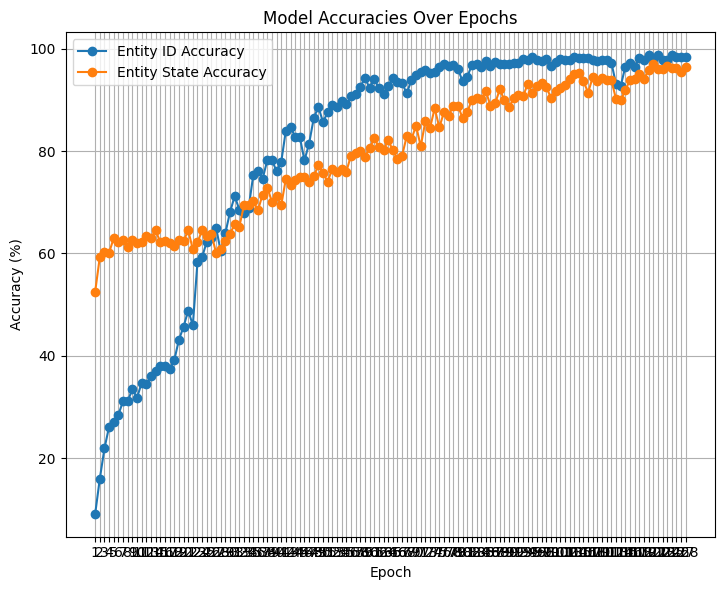

In [7]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, training_epoch + 1), entity_id_accuracies, marker='o', label='Entity ID Accuracy')
plt.plot(range(1, training_epoch + 1), entity_state_accuracies, marker='o', label='Entity State Accuracy')
plt.title('Model Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, training_epoch + 1))  # Set x-ticks to match epoch numbers
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Train the other heads separately with the transformer and embedding layer frozen

In [11]:
from os import listdir
from os.path import isfile, join
import re
data_root_path = './data/training_act'
data_pattern = r"^training_data_chunk_slim_.*?\d+\.parquet"
# Split the file list
train_files, test_files, eval_files = split_file_list(file_list, train_ratio=0.8, test_ratio=0.1, eval_ratio=0.1)

# Create separate datasets
train_dataset = MultiPartParquetCASASDataset(train_files, shuffle_files=True, shuffle_rows=True)
test_dataset = MultiPartParquetCASASDataset(test_files, shuffle_files=False, shuffle_rows=False)
eval_dataset = MultiPartParquetCASASDataset(eval_files, shuffle_files=False, shuffle_rows=False)

# Wrap them in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)


# Actionable Classification Criterion (binary classification)
actionable_classification_criterion = nn.CrossEntropyLoss()


In [12]:
def freeze_backbone_params(model):
    # Freeze the transformer and other heads
    for param in model.embedding.parameters():
        param.requires_grad = False
    
    for param in model.transformer.parameters():
        param.requires_grad = False
    
    for param in model.entity_id_fc.parameters():
        param.requires_grad = False
    
    for param in model.entity_state_fc.parameters():
        param.requires_grad = False
    return model

In [24]:
# Store accuracies and time prediction losses
def train_act_model_actionable_regression(model, dataloader, num_epochs, 
                actionable_classification_criterion, optimizer, device):
    actionable_losses = []
    model = freeze_backbone_params(model)
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_actionability_prediction = 0
        total_actionability_count = 0
        
        for batch_idx, (input_tensors_padded, curr_time_hint_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors) in tqdm(enumerate(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Assuming the dataloader returns a dictionary-like batch with relevant keys
            inputs = input_tensors_padded.to(device)  # shape: (batch_size, max_seq_length, input_dim)
            actionable_labels = actionable_tensors.to(device)
            time_hint_inputs = curr_time_hint_tensors.to(device)
            optimizer.zero_grad()
    
            # Forward pass
            actionable_output, entity_id_output, entity_state_output = model(inputs, additional_inputs=time_hint_inputs)
    
            # Calculate the loss
            actionable_loss = actionable_classification_criterion(actionable_output, actionable_labels)
            actionable_loss.backward()
            optimizer.step()

            # accumulate time pred losses
            actionable_loss += actionable_loss.item()

            # accumulate the epoch loss
            epoch_loss += actionable_loss.item()
            
            # Calculate entity ID classification accuracy
            _, actionable_prediction = torch.max(actionable_output, 1)
            correct_actionability_prediction += (actionable_prediction == actionable_labels).sum().item()
            total_actionability_count += actionable_labels.size(0)
            acctionablility_prediction_accuracy = 100 * correct_actionability_prediction / total_actionability_count
            
        avg_loss = epoch_loss / len(dataloader)
        actionable_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], actionable prediction acc: {acctionablility_prediction_accuracy:.2f}, actionable prediction loss: {avg_loss:.4f}")
    print(f'All done.')
    return actionable_losses

In [25]:
# Using Adam optimizer
import torch.optim as optim
learning_rate = 1e-4  # You can adjust the learning rate as needed
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# find the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actionability_training_epoch=30
actionable_losses = train_act_model_actionable_regression(model=model, dataloader=train_loader, num_epochs=actionability_training_epoch, 
            actionable_classification_criterion=actionable_classification_criterion, 
            optimizer=optimizer, device=device)

Epoch 1/30: 47it [00:38,  1.23it/s]


Epoch [1/30], actionable prediction acc: 92.98, actionable prediction loss: 0.4371


Epoch 2/30: 47it [00:37,  1.25it/s]


Epoch [2/30], actionable prediction acc: 93.14, actionable prediction loss: 0.4081


Epoch 3/30: 47it [00:35,  1.34it/s]


Epoch [3/30], actionable prediction acc: 92.91, actionable prediction loss: 0.4077


Epoch 4/30: 47it [00:35,  1.33it/s]


Epoch [4/30], actionable prediction acc: 93.18, actionable prediction loss: 0.4026


Epoch 5/30: 47it [00:36,  1.29it/s]


Epoch [5/30], actionable prediction acc: 93.51, actionable prediction loss: 0.3853


Epoch 6/30: 47it [00:36,  1.30it/s]


Epoch [6/30], actionable prediction acc: 93.28, actionable prediction loss: 0.3962


Epoch 7/30: 47it [00:35,  1.34it/s]


Epoch [7/30], actionable prediction acc: 93.44, actionable prediction loss: 0.3842


Epoch 8/30: 47it [00:41,  1.12it/s]


Epoch [8/30], actionable prediction acc: 93.68, actionable prediction loss: 0.3752


Epoch 9/30: 47it [00:45,  1.02it/s]


Epoch [9/30], actionable prediction acc: 94.31, actionable prediction loss: 0.3693


Epoch 10/30: 47it [00:38,  1.21it/s]


Epoch [10/30], actionable prediction acc: 94.31, actionable prediction loss: 0.3581


Epoch 11/30: 47it [00:38,  1.23it/s]


Epoch [11/30], actionable prediction acc: 94.38, actionable prediction loss: 0.3603


Epoch 12/30: 47it [00:36,  1.28it/s]


Epoch [12/30], actionable prediction acc: 93.81, actionable prediction loss: 0.3750


Epoch 13/30: 47it [00:38,  1.24it/s]


Epoch [13/30], actionable prediction acc: 94.62, actionable prediction loss: 0.3624


Epoch 14/30: 47it [00:38,  1.22it/s]


Epoch [14/30], actionable prediction acc: 94.38, actionable prediction loss: 0.3561


Epoch 15/30: 47it [00:37,  1.26it/s]


Epoch [15/30], actionable prediction acc: 95.12, actionable prediction loss: 0.3437


Epoch 16/30: 47it [00:34,  1.35it/s]


Epoch [16/30], actionable prediction acc: 94.62, actionable prediction loss: 0.3532


Epoch 17/30: 47it [00:37,  1.26it/s]


Epoch [17/30], actionable prediction acc: 94.31, actionable prediction loss: 0.3594


Epoch 18/30: 47it [00:38,  1.23it/s]


Epoch [18/30], actionable prediction acc: 94.98, actionable prediction loss: 0.3448


Epoch 19/30: 47it [00:35,  1.32it/s]


Epoch [19/30], actionable prediction acc: 94.38, actionable prediction loss: 0.3521


Epoch 20/30: 47it [00:37,  1.25it/s]


Epoch [20/30], actionable prediction acc: 94.68, actionable prediction loss: 0.3438


Epoch 21/30: 47it [00:34,  1.36it/s]


Epoch [21/30], actionable prediction acc: 95.45, actionable prediction loss: 0.3453


Epoch 22/30: 47it [00:34,  1.36it/s]


Epoch [22/30], actionable prediction acc: 95.45, actionable prediction loss: 0.3371


Epoch 23/30: 47it [00:38,  1.23it/s]


Epoch [23/30], actionable prediction acc: 95.15, actionable prediction loss: 0.3371


Epoch 24/30: 47it [00:39,  1.20it/s]


Epoch [24/30], actionable prediction acc: 94.98, actionable prediction loss: 0.3369


Epoch 25/30: 47it [00:36,  1.28it/s]


Epoch [25/30], actionable prediction acc: 94.98, actionable prediction loss: 0.3489


Epoch 26/30: 47it [00:39,  1.19it/s]


Epoch [26/30], actionable prediction acc: 95.65, actionable prediction loss: 0.3293


Epoch 27/30: 47it [00:39,  1.19it/s]


Epoch [27/30], actionable prediction acc: 95.32, actionable prediction loss: 0.3297


Epoch 28/30: 47it [00:40,  1.15it/s]


Epoch [28/30], actionable prediction acc: 95.55, actionable prediction loss: 0.3261


Epoch 29/30: 47it [00:37,  1.24it/s]


Epoch [29/30], actionable prediction acc: 95.28, actionable prediction loss: 0.3295


Epoch 30/30: 47it [00:40,  1.17it/s]


Epoch [30/30], actionable prediction acc: 95.02, actionable prediction loss: 0.3350
All done.


In [29]:
torch.save(model.state_dict(), model_save_path)

# Eval

In [30]:
loaded_model = TransformerMultiTask(input_dim=46, hidden_dim=512, additional_input_dim=5, num_heads=2, num_layers=1, entity_id_cls=45, entity_state_cls=4)
# Load the state dict
loaded_model.load_state_dict(torch.load(model_save_path, weights_only=True))
loaded_model.eval()  # Set the model to evaluation mode

TransformerMultiTask(
  (embedding): Linear(in_features=46, out_features=512, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (actionable_fc): Linear(in_features=517, out_features=2, bias=True)
  (entity_id_fc): Sequential(
    (0): Linear(in_features=517, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=

In [45]:
def evaluate_model(model, test_dataloader, device):
    model.eval()  # Set model to evaluation mode
    actionable_correct, actionable_total = 0, 0
    entity_id_correct, entity_id_total = 0, 0
    entity_state_correct, entity_state_total = 0, 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in test_dataloader:
            input_tensors_padded, curr_time_hint_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors = batch
            
            # Move data to the correct device
            inputs = input_tensors_padded.to(device)  # shape: (batch_size, max_seq_length, input_dim)
            time_hint_inputs = curr_time_hint_tensors.to(device)
            actionable_labels = actionable_tensors.to(device)  # shape: (batch_size,)
            entity_id_labels = action_entity_id_tensors.to(device)  # shape: (batch_size,)
            entity_state_labels = action_entity_state_tensors.to(device)  # shape: (batch_size,)
            
            # Inference
            actionable_output, entity_id_output, entity_state_output = model(inputs, additional_inputs=time_hint_inputs)
            
            # Get actionable predictions
            actionable_pred = torch.argmax(actionable_output, dim=1)
            actionable_correct += (actionable_pred == actionable_labels).sum().item()
            actionable_total += actionable_labels.size(0)

            # Get entity ID predictions
            entity_id_pred = torch.argmax(entity_id_output, dim=1)
            entity_id_correct += (entity_id_pred == entity_id_labels).sum().item()
            entity_id_total += entity_id_labels.size(0)

            # Get entity state predictions
            entity_state_pred = torch.argmax(entity_state_output, dim=1)
            entity_state_correct += (entity_state_pred == entity_state_labels).sum().item()
            entity_state_total += entity_state_labels.size(0)

    # Calculate accuracies as a percentage
    actionable_accuracy = actionable_correct / actionable_total * 100
    entity_id_accuracy = entity_id_correct / entity_id_total * 100
    entity_state_accuracy = entity_state_correct / entity_state_total * 100

    return {
        'actionable_accuracy': actionable_accuracy,
        'entity_id_accuracy': entity_id_accuracy,
        'entity_state_accuracy': entity_state_accuracy
    }

In [46]:
results = evaluate_model(model, test_loader, device=device)
print(f"Actionable Accuracy: {results['actionable_accuracy']} %")
print(f"Entity ID Accuracy: {results['entity_id_accuracy']} %")
print(f"Entity State Accuracy: {results['entity_state_accuracy']} %")

ZeroDivisionError: division by zero